In [2]:
import numpy as np
from qiskit.pulse import Drag, DriveChannel, GaussianSquare, Play, Schedule, ShiftPhase, builder
from qiskit.transpiler.passes import CommutativeCancellation, RZXCalibrationBuilder
from qiskit.transpiler.passes.calibration.base_builder import CalibrationBuilder
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import InstructionProperties
from qiskit_experiments.library import StandardRB, InterleavedRB
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
service = QiskitRuntimeService(channel='ibm_quantum')

In [4]:
backend = service.get_backend('ibmq_mumbai')

In [5]:
inst_map = backend.instruction_schedule_map
channel_map = backend.configuration()._qubit_channel_map

In [6]:
def rx_calibration(theta, qubit, inst_map):
    x_sched = inst_map.get("sx", qubits=(qubit))
    inst = x_sched.instructions[0][1]
    x_pulse = inst.pulse
    amp_scale = (1 + theta / np.pi) % 2 - 1
    x1 = Drag(
                amp=x_pulse.amp * amp_scale * 2,
                sigma=x_pulse.sigma,
                duration=x_pulse.duration,
                beta=x_pulse.beta,
            )
    with builder.build(name = "rx(%.3f)", schedule=x_sched) as rx_sched:
        if theta == 0.0:
            return rx_sched
        builder.play(x1, channel=inst.channel)
        print(rx_sched)
    return rx_sched

In [7]:
custom_rx_sched = rx_calibration(np.pi, 0, inst_map)

ScheduleBlock(Play(Drag(duration=160, sigma=40, beta=-0.18420542836138282, amp=0.08150946589838083, angle=0.004292052994166887, name='X90p_d0'), DriveChannel(0), name='X90p_d0'), name="rx(%.3f)", transform=AlignLeft())


/Users/amey/anaconda3/envs/randomized_benchmarking/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


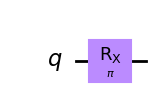

In [8]:
circuit = QuantumCircuit(1, name='custom_rx')
circuit.rx(np.pi,0)
circuit.draw(output='mpl')

In [9]:
#from qiskit.providers import BackendV2Converter
#backend_v2 = copy.deepcopy(BackendV2Converter(backend)) #if the version of your backend is not 2(backend.version), use the converter
# append the calibrations of the custom gate
custom_rx = circuit.to_gate()
backend.target.add_instruction(custom_rx, {(0,): InstructionProperties(calibration=custom_rx_sched)}) # attach the calibation directly to the backend

In [10]:
lengths = np.arange(1, 200, 30)
num_samples = 10
seed = 1010
qubits = [0] # make sure it is the qubit added in the backend target

int_exp = InterleavedRB(
    custom_rx, qubits, lengths, num_samples=num_samples, seed=seed, backend=backend)

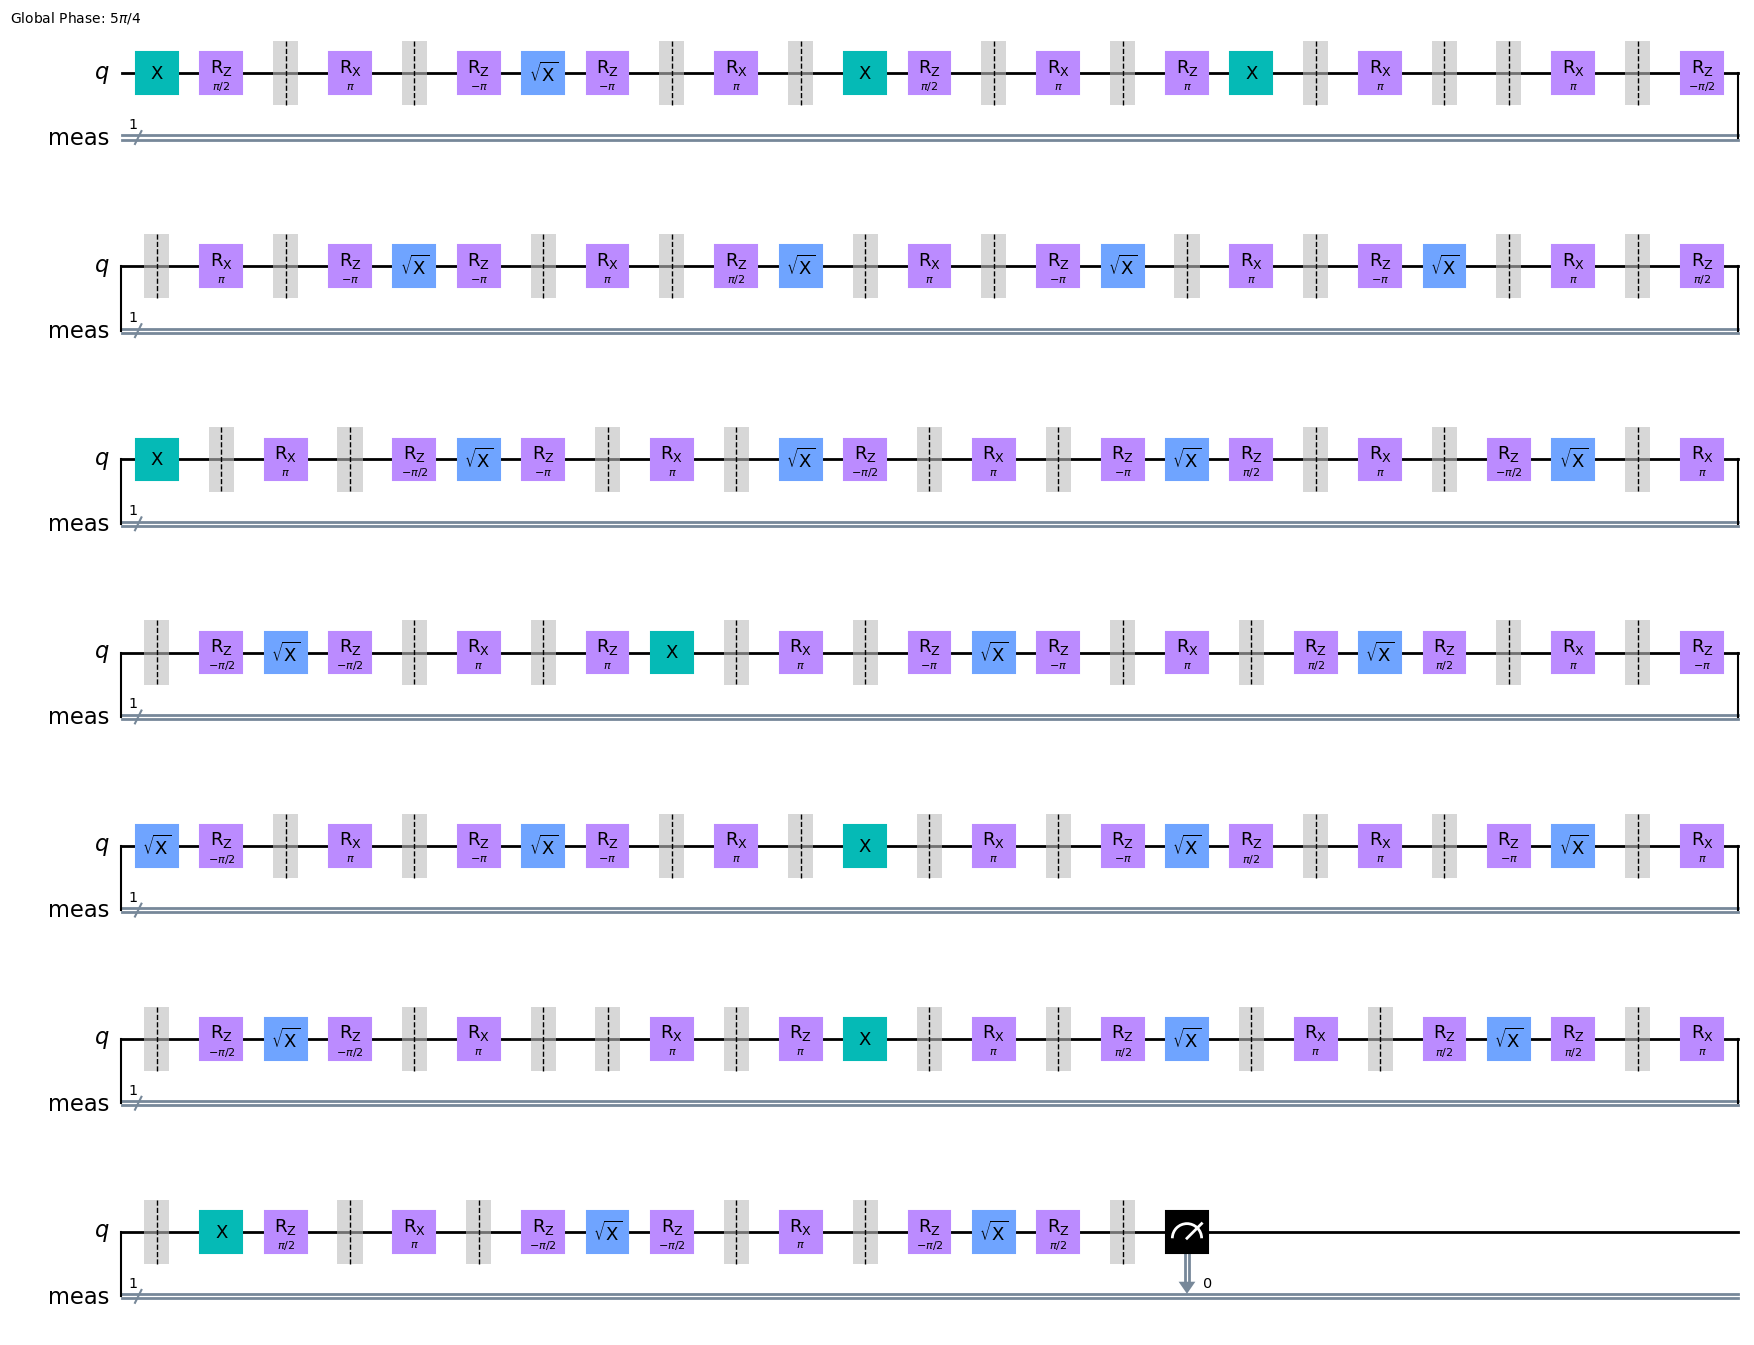

In [14]:
int_exp.circuits()[3].decompose().draw('mpl')

In [15]:
int_expdata = int_exp.run(backend).block_for_results()
int_results = int_expdata.analysis_results()

/Users/amey/anaconda3/envs/randomized_benchmarking/lib/python3.12/site-packages/qiskit_ibm_runtime/ibm_backend.py:694: UserWarning: The backend ibmq_mumbai is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


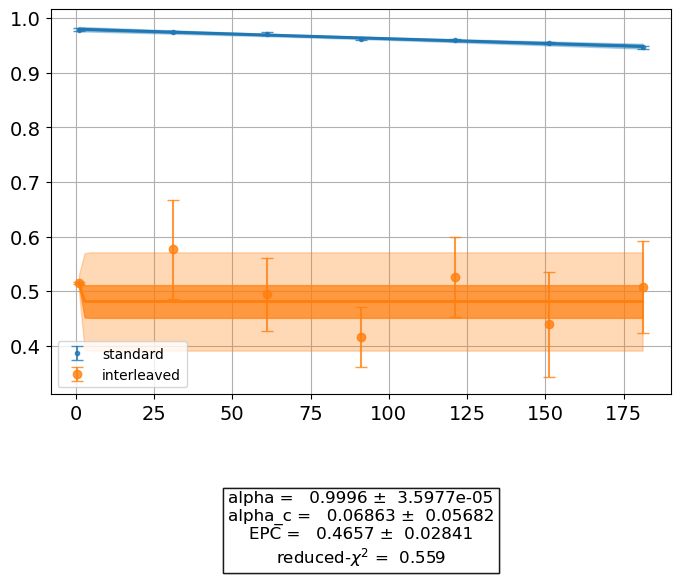

AnalysisResult
- name: @Parameters_InterleavedRBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 2
  * F_standard(x) = a * alpha ** x + b
  * F_interleaved(x) = a * (alpha_c * alpha) ** x + b
 - success: True
 - number of function evals: 14
 - degree of freedom: 10
 - chi-square: 5.589700783975702
 - reduced chi-square: 0.5589700783975702
 - Akaike info crit.: -4.853841992568384
 - Bayesian info crit.: -2.2976126741073504
 - init params:
  * a = 0.24719352504757452
  * alpha = 0.9996178926701439
  * b = 0.5
  * alpha_c = 1.0
 - fit params:
  * a = 0.49915598696628216 ± 0.03002560952064655
  * alpha = 0.9996399949612548 ± 3.597738008759423e-05
  * b = 0.48112854518435305 ± 0.030003558749885837
  * alpha_c = 0.06862572998176576 ± 0.05681506365537531
 - correlations:
  * (a, b) = -0.998947817376614
  * (b, alpha_c) = -0.9857423040118394
  * (alpha, b) = -0.6210403496568032
  * (a, alpha) = 0.5907993436665391
  * (alpha, alpha_c) = 0.6143087909700

In [11]:
# View result data
display(int_expdata.figure(0))
for result in int_results:
    print(result)

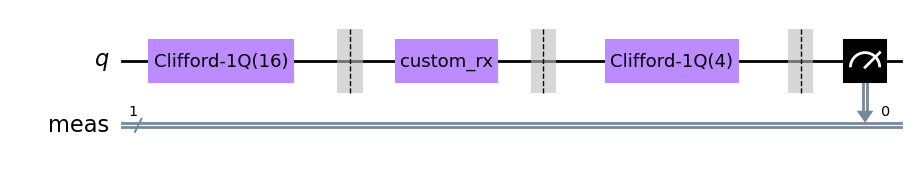

In [13]:
int_exp.circuits()[1].draw(output='mpl')

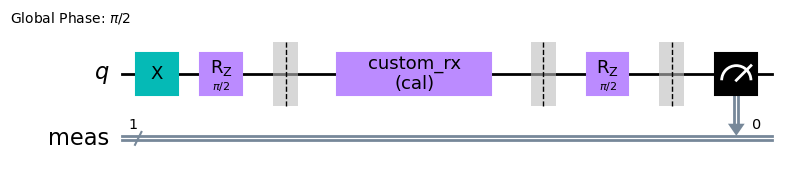

In [17]:
# you can see that the transpiled circuits contain the calibrations
int_exp._transpiled_circuits()[1].draw(output='mpl')